# Brain Tumor Classification With SegNet's Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2

### Data Preparation

In [2]:
def get_df(original_images_dir, masked_images_dir):
    class_names = os.listdir(original_images_dir)

    original_file_path = []
    masked_file_path = []
    classes = []
    for class_name in class_names:
        for file_name in os.listdir(os.path.join(original_images_dir, class_name)):
            masked_file_path.append(os.path.join(masked_images_dir, class_name, file_name))
            original_file_path.append(os.path.join(original_images_dir, class_name, file_name))
            classes.append(class_name)

    df = pd.DataFrame({
        "OriginalPath": original_file_path,
        "MaskedPath": masked_file_path,
        "Class": classes
    })

    return df

In [3]:
train_df = get_df("../data/original/original/Training", "../data/segnet/segnet/Training")
test_df = get_df("../data/original/original/Testing", "../data/segnet/segnet/Testing")

### Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
valid_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 42, stratify = test_df["Class"], shuffle = True)

In [6]:
class_names = sorted(train_df['Class'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}

def load_and_combine(image_path, mask_path):
    # Load and decode image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Use channels=1 for grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    # Resize if needed (optional)
    image = tf.image.resize(image, [224, 224])
    mask = tf.image.resize(mask, [224, 224])

    # Concatenate along the channel axis
    combined = tf.concat([image, mask], axis = -1)  # Shape: (H, W, 2)

    return combined

def preprocess(image_path, mask_path, label):
    combined = load_and_combine(image_path, mask_path)
    label_one_hot = tf.one_hot(label, depth=4)
    return combined, label_one_hot

def create_dataset(df, class_to_index, batch_size=32, shuffle=True):
    image_paths = df["OriginalPath"].values
    mask_paths = df["MaskedPath"].values
    labels = df["Class"].map(class_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    ds = ds.map(lambda x, y, z: preprocess(x, y, z), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
train_ds = create_dataset(train_df, class_to_index)
valid_ds = create_dataset(valid_df, class_to_index, shuffle = False)
test_ds = create_dataset(test_df, class_to_index, shuffle = False)

### Modeling

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
y_true = test_df["Class"].map(class_to_index)

In [10]:
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes = 4)

##### 1. CNN

In [11]:
def get_feature_extractor():
    cnn = tf.keras.models.Sequential()    

    # Convulational Layer 1
    cnn.add(tf.keras.layers.Conv2D(
        filters = 32, 
        kernel_size = 3, 
        input_shape = [224, 224, 2], 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 1
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 2
    cnn.add(tf.keras.layers.Conv2D(
        filters = 64, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 2
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 3
    cnn.add(tf.keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 3
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 4
    cnn.add(tf.keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 4
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))  
 
    # Flatten Layer 
    cnn.add(tf.keras.layers.Flatten())  

    return cnn  

In [12]:
cnn = get_feature_extractor()

# Fully Connected Layer 1
cnn.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())


# Droput Layer
cnn.add(tf.keras.layers.Dropout(0.4))

# Output Layer
cnn.add(tf.keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      608       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 10, 
    restore_best_weights = True
)

In [15]:
cnn.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tf.keras.metrics.Recall()]
)

In [16]:
history = cnn.fit(
    train_ds, 
    validation_data = valid_ds, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
179/179 [==============================] - 24s 87ms/step - loss: 0.5146 - recall: 0.7878 - val_loss: 1.7753 - val_recall: 0.2290
Epoch 2/100
179/179 [==============================] - 17s 85ms/step - loss: 0.2364 - recall: 0.9205 - val_loss: 0.8612 - val_recall: 0.5573
Epoch 3/100
179/179 [==============================] - 18s 85ms/step - loss: 0.1473 - recall: 0.9573 - val_loss: 0.3524 - val_recall: 0.8718
Epoch 4/100
179/179 [==============================] - 18s 85ms/step - loss: 0.1111 - recall: 0.9734 - val_loss: 0.1626 - val_recall: 0.9405
Epoch 5/100
179/179 [==============================] - 18s 85ms/step - loss: 0.0898 - recall: 0.9842 - val_loss: 0.1993 - val_recall: 0.9359
Epoch 6/100
179/179 [==============================] - 18s 86ms/step - loss: 0.0638 - recall: 0.9937 - val_loss: 0.1407 - val_recall: 0.9634
Epoch 7/100
179/179 [==============================] - 18s 85ms/step - loss: 0.0581 - recall: 0.9947 - val_loss: 0.1021 - val_recall: 0.9710
Epoch 8/100
1

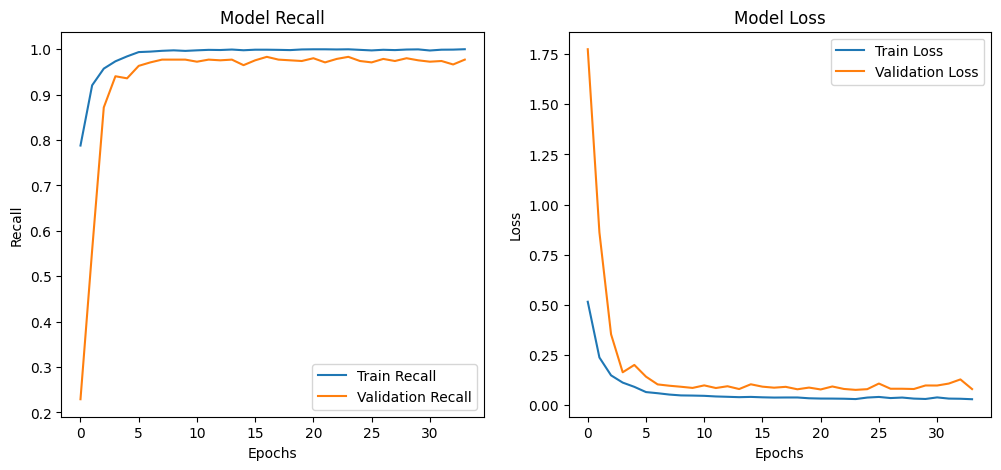

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(history.history["recall"], label = "Train Recall")
axes[0].plot(history.history["val_recall"], label = "Validation Recall")
axes[0].set_title("Model Recall")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Recall")
axes[0].legend()

axes[1].plot(history.history["loss"], label = "Train Loss")
axes[1].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

In [18]:
y_prob_cnn = cnn.predict(test_ds)
y_pred_cnn= np.argmax(y_prob_cnn, axis = 1)

21/21 [==============================] - 1s 22ms/step


In [19]:
print(confusion_matrix(y_true, y_pred_cnn))
print(classification_report(y_true, y_pred_cnn, target_names = class_names))

[[145   4   0   1]
 [  5 144   3   1]
 [  0   0 203   0]
 [  0   0   0 150]]
              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       150
  meningioma       0.97      0.94      0.96       153
     notumor       0.99      1.00      0.99       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [20]:
cnn.save("../models/cnn-segnet")

INFO:tensorflow:Assets written to: ../models/cnn-segnet\assets


INFO:tensorflow:Assets written to: ../models/cnn-segnet\assets


##### CNN-XGBoost

In [21]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [22]:
def extract_features(dataset, model):
    features = []
    labels = []
    
    for images, label in dataset:
        # Get CNN features
        f = model(images, training=False)  # shape: (batch_size, feature_dim)
        features.append(f.numpy())
        labels.append(label.numpy())

    # Combine all batches into arrays
    return np.vstack(features), np.argmax(np.concatenate(labels), axis = 1)

In [23]:
feature_extractor = get_feature_extractor()

In [24]:
X_train, y_train = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(valid_ds, feature_extractor)
X_test, y_test = extract_features(test_ds, feature_extractor)

In [25]:
xgb = XGBClassifier(
    objective = 'multi:softmax',
    num_class = 4,
    eval_metric = 'mlogloss',
    use_label_encoder = False,
    early_stopping_rounds=10    
)

xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = True)

c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [21:27:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.02351
[1]	validation_0-mlogloss:0.81094
[2]	validation_0-mlogloss:0.67190
[3]	validation_0-mlogloss:0.57584
[4]	validation_0-mlogloss:0.49747
[5]	validation_0-mlogloss:0.43663
[6]	validation_0-mlogloss:0.38960
[7]	validation_0-mlogloss:0.35027
[8]	validation_0-mlogloss:0.31831
[9]	validation_0-mlogloss:0.29286
[10]	validation_0-mlogloss:0.27348
[11]	validation_0-mlogloss:0.25714
[12]	validation_0-mlogloss:0.24154
[13]	validation_0-mlogloss:0.22913
[14]	validation_0-mlogloss:0.21705
[15]	validation_0-mlogloss:0.20734
[16]	validation_0-mlogloss:0.19935
[17]	validation_0-mlogloss:0.19171
[18]	validation_0-mlogloss:0.18404
[19]	validation_0-mlogloss:0.17994
[20]	validation_0-mlogloss:0.17424
[21]	validation_0-mlogloss:0.16843
[22]	validation_0-mlogloss:0.16420
[23]	validation_0-mlogloss:0.16508
[24]	validation_0-mlogloss:0.16319
[25]	validation_0-mlogloss:0.16156
[26]	validation_0-mlogloss:0.15941
[27]	validation_0-mlogloss:0.15582
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4, ...)

In [26]:
y_pred_xgb = xgb.predict(X_test)

In [27]:
print(confusion_matrix(y_true, y_pred_xgb))
print(classification_report(y_true, y_pred_xgb, target_names = class_names))

[[127  22   0   1]
 [  3 143   6   1]
 [  0   0 203   0]
 [  0   1   0 149]]
              precision    recall  f1-score   support

      glioma       0.98      0.85      0.91       150
  meningioma       0.86      0.93      0.90       153
     notumor       0.97      1.00      0.99       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.95       656
   macro avg       0.95      0.94      0.94       656
weighted avg       0.95      0.95      0.95       656

